<div class="alert alert-info">
View notebook in interactive mode for using hyperlinks and correct display of markdown:<br>
<a href='https://nbviewer.org/github/yulianikola/portfolio/blob/master/english/data_analysis_python/bank_bitcoin_match/bank_bitcoin_match.ipynb'>bank_bitcoin_match</a></div>

### "FinCEN Suspicious Activity Report" challenge
https://github.com/inca-digital/challenge/issues/61

Data sources:
* Large Bitcoin blockchain transactions (Inca Digital google drive)
* Bitcoin-USD historical pricing (Inca Digital google drive)
* FinCEN SAR dataset
https://www.icij.org/investigations/fincen-files/download-fincen-files-transaction-data/

Challenge:<br>
find suspiciously similar bank and Bitcoin transactions 

<p id="0">
Table of contents:
<ul type="square"><a href="#1"><li>Preparation of FinCEN dataset</li></a>
<a href="#2"><li>Preparation of Bitcoin prices dataset</li></a>
<a href="#3"><li>Bitcoin transactions dataset</li></a>
    <ul><a href="#3.1"><li>Correction of file</li></a>
        <a href="#3.2"><li>Preparation of dataframe</li></a> </ul>
<a href="#5"><li>Matching bank and Bitcoin transactions</li></a>
    <ul><a href="#5.1"><li>Conditional join</li></a>
     <a href="#5.2"><li>Explore the result</li></a>  
     <a href="#5.3"><li>Bitcoin "chains"?</li></a>  
    </ul>

In [1]:
import pandas as pd
import numpy as np

<h4>Preparation of FinCEN dataset</h4>
<p id="1">

In [2]:
fin_trans_raw = pd.read_csv('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\data\\download_transactions_map.csv',
                        parse_dates = ['begin_date','end_date'], dayfirst = True)

In [3]:
fin_trans = fin_trans_raw.copy()
fin_trans.head(2)

,id,icij_sar_id,filer_org_name_id,filer_org_name,begin_date,end_date,originator_bank_id,originator_bank,originator_bank_country,originator_iso,beneficiary_bank_id,beneficiary_bank,beneficiary_bank_country,beneficiary_iso,number_transactions,amount_transactions
0,223254,3297,the-bank-of-new-york-mellon-corp,The Bank of New York Mellon Corp.,2015-03-25,2015-09-25,cimb-bank-berhad,CIMB Bank Berhad,Singapore,SGP,barclays-bank-plc-london-england-gbr,Barclays Bank Plc,United Kingdom,GBR,68.0,5.689852e+07
1,223255,3297,the-bank-of-new-york-mellon-corp,The Bank of New York Mellon Corp.,2015-03-30,2015-09-25,cimb-bank-berhad,CIMB Bank Berhad,Singapore,SGP,barclays-bank-plc-london-england-gbr,Barclays Bank Plc,United Kingdom,GBR,118.0,1.162384e+08


In [4]:
pd.set_option("precision", 4)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

Few nulls in date columns and some nulls in 'number_transactions':

In [5]:
fin_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        4507 non-null   int64         
 1   icij_sar_id               4507 non-null   int64         
 2   filer_org_name_id         4507 non-null   object        
 3   filer_org_name            4507 non-null   object        
 4   begin_date                4501 non-null   datetime64[ns]
 5   end_date                  4501 non-null   datetime64[ns]
 6   originator_bank_id        4507 non-null   object        
 7   originator_bank           4507 non-null   object        
 8   originator_bank_country   4507 non-null   object        
 9   originator_iso            4507 non-null   object        
 10  beneficiary_bank_id       4507 non-null   object        
 11  beneficiary_bank          4507 non-null   object        
 12  beneficiary_bank_cou

No duplicates in 'id' column:

In [6]:
len(fin_trans) - fin_trans.id.nunique()

0

But there are duplicate rows (excluding 'id' column):

In [7]:
fin_trans.duplicated(list(fin_trans.columns[1:]), keep = False).value_counts()

False    4430
True       77
dtype: int64

Even more duplicates when excluding 'id' and 'icij_sar_id' columns. Meaning that there are duplicates not only within the same icij_sar_id, but also between different icij_sar_id.

In [8]:
fin_trans.duplicated(list(fin_trans.columns[2:]), keep = False).value_counts()

False    4422
True       85
dtype: int64

Mostly 2 duplicates of one row, but there is one row with 24 duplicates:

In [9]:
(fin_trans[fin_trans.duplicated(list(fin_trans.columns[2:]), keep = False)].
 groupby(['begin_date','end_date','originator_bank_id','beneficiary_bank_id',
          'number_transactions', 'amount_transactions'])['id'].count().
 to_frame().sort_values('id', ascending = False).head())

,,,,,,id
begin_date,end_date,originator_bank_id,beneficiary_bank_id,number_transactions,amount_transactions,
2011-07-14,2011-07-14,unicredit-bank-cjsc,rosbank-moscow-russia-rus,1.00,100000.00,24
2012-01-27,2012-01-27,banque-internationale-pour-le-commerce-et-lindustrie,habib-bank-a-g-zurich-dubaiuae-are,1.00,12075.00,3
2011-06-29,2011-06-29,standard-chartered-bank-hk-ltd,bank-of-china-jiangxi-china-chn,1.00,49999.00,3
2012-08-17,2012-08-17,ltb-bank,bank-soyuz-moscow-russia-rus,1.00,500000.00,2
2016-05-13,2016-05-13,rosbank,credit-bank-of-moscow-ojsc-moscow-russia-rus,1.00,4750000.00,2


Probably it might happen that transactions through the same banks of the same amount on the same date were actually different (due to different transaction details) or actually repeated several times but not combined in one row in the dataset. ICIJ has not replied to my email regarding duplicates.<br>
Decision regarding duplicates requires a deeper understanding of a data collection mechanism. But for the given challenge dropping duplicates should not be a problem. Because the task is to find Bitcoin transactions similar to bank transactions. And the fact that the fin_trans dataset contains several duplicates of some transactions (even with different 'id' or 'icij_sar_id' values) does not seem to add valuable information. Thus drop duplicates. But in the following it will be possible to check whether a transaction has duplicates in the initial dataset.

In [10]:
fin_trans = fin_trans.drop_duplicates(list(fin_trans.columns[2:]), keep = 'first')

In [11]:
len(fin_trans)

4452

Date is crucial for the given challenge, so drop the rows with nulls in 'begin_date'/'end_date' columns. Nulls in 'begin_date' and 'end_date' are in the same rows:

In [12]:
fin_trans[fin_trans.begin_date.isna()].index == fin_trans[fin_trans.end_date.isna()].index

array([ True,  True,  True,  True,  True,  True])

In [13]:
fin_trans = fin_trans[fin_trans.begin_date.notna()]

In [14]:
fin_trans.begin_date.notna().mean()

1.0

Number of transactions varies from 1 to 174. Rows with the number of transactions more than 1 are transactions combined in one row (or SAR) for some reason. It could be that such transactions were considered as parts of "one" or have the same transaction details. If for the purpose of the challenge only one-transaction rows should be considered, then nulls can be dropped. But keep the nulls so far and filter later if needed.

Have not found the transaction mentioned in the challenge description. For the same 'originator_bank', 'filer_org_name' and 'beneficiary_bank' there is no row with 15/01/2016 date. But there is a row with period (2016-01-14; 2016-01-19) (includes 15/01/2016) and total amount of 1 000 000, though number of transactions equals 2.

In [15]:
(fin_trans[(fin_trans.filer_org_name  == 'China Investment Corporation') &
          (fin_trans.originator_bank  == 'Bank of China') &
          (fin_trans.beneficiary_bank  == 'Saigon Thuong Tin Commercial Joint Stock Bank')]
 [['filer_org_name', 'originator_bank', 'beneficiary_bank', 'begin_date', 'end_date',
  'number_transactions', 'amount_transactions']])

,filer_org_name,originator_bank,beneficiary_bank,begin_date,end_date,number_transactions,amount_transactions
1385,China Investment Corporation,Bank of China,Saigon Thuong Tin Commercial Joint Stock Bank,2016-02-01,2016-02-01,1.00,500000.00
1386,China Investment Corporation,Bank of China,Saigon Thuong Tin Commercial Joint Stock Bank,2016-05-07,2016-05-07,1.00,600000.00
1388,China Investment Corporation,Bank of China,Saigon Thuong Tin Commercial Joint Stock Bank,2016-01-14,2016-01-19,2.00,1000000.00
1391,China Investment Corporation,Bank of China,Saigon Thuong Tin Commercial Joint Stock Bank,2016-01-07,2016-01-07,1.00,1515165.60


The dataset cover transactions from February 2000 to November 2017:

In [16]:
print(fin_trans.begin_date.min())
print(fin_trans.end_date.max())

2000-02-08 00:00:00
2017-11-03 00:00:00


<a href="#0"><h4>Back to top</h4></a>

<h4>Preparation of Bitcoin pricing dataset</h4>
<p id="2">

In [17]:
import glob
import os

In [18]:
price_files = glob.glob('C:/python/portfolio/english/data_analysis_python/bank_bitcoin_match/data/btc_avg_price/' + "/*.csv")
prices = pd.concat((pd.read_csv(f, parse_dates=['time'], dayfirst = True) for f in price_files))
prices.head(2)

,time,price
0,2010-07-18,0.05
1,2010-07-19,0.09


In [19]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4185 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    4185 non-null   datetime64[ns]
 1   price   4013 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 98.1 KB


Price is crucial for the given challenge, so drop nulls:

In [20]:
prices = prices.dropna()

No duplicates:

In [21]:
prices.duplicated(keep = False).value_counts()

False    4013
dtype: int64

In [22]:
prices.columns = ['date', 'price']

The dataset contains prices from July 2010 to July 2021:

In [23]:
print(prices.date.min())
print(prices.date.max())

2010-07-18 00:00:00
2021-07-18 00:00:00


<a href="#0"><h4>Back to top</h4></a>

<h4>Bitcoin transactions dataset</h4>
<p id="3">

<h5>Correction of csv file</h5>
<p id="3.1">

Parsing of the csv file in pandas raised the error message "Expected 5 fields in line 12136, saw 13.", which means that there is a line with a different number of columns. Probably there could be other errors, so discover file by line.

In [24]:
f = open('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\data\\btc_tx.csv')

Number of lines in the file:

In [25]:
f.seek(0)
for i,line in enumerate(f):
    pass
print(i+1)

380612


Column names:

In [26]:
f.seek(0)
f.readline()

'"time","Hash","Sender","Receiver","Transaction_amount_BTC"\n'

First line of data:

In [27]:
f.readline()

'"2015-03-31","16f27194b06bcf1f61b1531a2a861fdcd027a23242809003a051380ae398492f","1BtNH4rtj3PVe6PWYsziQMnXofZmoPmGHu","1PrGFmmFFeD6v9ihS74ewjAzSMmQxsQAuw","5272.9999"\n'

Values in columns are put between quotation marks. Lines contain different quantity of quotation marks, better to replace in order to avoid errors:

In [28]:
f.seek(0)
quot_list = []
for line in f:
    if line.count('"') not in quot_list:
        quot_list.append(line.count('"'))
len(quot_list)

238

Mostly 4 commas in a line, but there are also lines with no commas and with 8 commas:

In [29]:
f.seek(0)
n_com_dict = {}
for line in f:
    if line.count(',') in n_com_dict:
        n_com_dict[line.count(',')] +=1
    else:
        n_com_dict[line.count(',')] = 1
n_com_dict

{4: 380400, 0: 211, 8: 1}

The line with 8 commas looks like two sticked lines:

In [30]:
f.seek(0)
for line in f:
    if line.count(',') == 8:
        print(line)

"2015-12-01","68365757c208fa14e2de0b36e97e007476e253dcdd4ae2134e3cff88a7408b66","1FizmYjFiFJezoaCBVVuGQyySYX3oFbQLU","16xFzWwU9AZZT4wa1Dc5rcmw7xKVbZczk7","15 " ""2015-12-01","68365757c208fa14e2de0b36e97e007476e253dcdd4ae2134e3cff88a7408b66","1FizmYjFiFJezoaCBVVuGQyySYX3oFbQLU","1FVT6QaTjWDJrF4hxSXoo7pNZdLd7LdU5q","0.125005""



Lines with no commas: 203 "empty" lines with new line symbol and 7 lines with a number:

In [31]:
f.seek(0)
zero_com_dict = {}
for line in f:
    if line.count(',') == 0:
        if line in zero_com_dict:
            zero_com_dict[line] += 1
        else:
            zero_com_dict[line] = 1
zero_com_dict

{'\n': 203, '"20 "\n': 7, '"200 "\n': 1}

Check the adjacent lines of lines with numbers:

In [32]:
f.seek(0)
zero_com_list = []
for i,line in enumerate(f):
    if line == '"20 "\n' or line == '"200 "\n':
        zero_com_list.append(i)
len(zero_com_list)

8

In [33]:
zero_com_list_prev_fol = sorted(zero_com_list + [i-1 for i in zero_com_list] + [i+1 for i in zero_com_list])

Lines with numbers look like the fifth column of preceding lines (output limited for the sake of space):

In [34]:
f.seek(0)
n = 0
for i,line in enumerate(f):
    if i in zero_com_list_prev_fol:
        n += 1
        print(line)        
        if n >= 3:
            break

"2015-12-01","4b51ee566bb05dcd24fcaa74f4305f337dc2f2fb80b7ea6dba7788dcb8ac2b58","1EfURQFm4GFq5uiNDcfEm9ip5aukTgdqGm 18SLaMRnNbciHMYmu2DacF53N8VmSBCsdj","38KyQwcadXTL5HA4dK1xzuUrht5oahkBEb","

"20 "





The first column should be convertible to datetime type. No errors here:

In [35]:
from datetime import datetime

In [36]:
f.seek(0)
f.readline() # skip the header, no date there
date_err_list = []
for line in f:
    if line.count(',') == 4:
        try:
            datetime.strptime(line.replace('"','').strip().split(',')[0],'%Y-%m-%d')
        except ValueError:
            date_err_list.append(line.replace('"','').strip().split(',')[0])
print(len(date_err_list)) 

0


The last column with amount should be convertible to float type. 10 errors are found with either an empty column or letter "d". 

In [37]:
f.seek(0)
f.readline() # skip the header, no amount there
amount_err_list = []
amount_err_n_list = []
for i,line in enumerate(f):
    if line.count(',') == 4:
        try:
            float(line.replace('"','').strip().split(',')[4])
        except ValueError:
            amount_err_list.append(line.replace('"','').strip().split(',')[4])
            amount_err_n_list.append(i)
print(len(amount_err_list)) 
amount_err_list 

10


['', 'd', '', '', '', 'd', '', '', '', '']

Check the adjacent lines:

In [38]:
amount_err_n_list_prev_fol = sorted(amount_err_n_list + [i-1 for i in amount_err_n_list] + [i+1 for i in amount_err_n_list])

Lines with empty amount column are the preceding lines of lines with a number, which were mentioned above (output limited for the sake of space). Lines with letter "d" are surrounded by correct lines, so letter "d" will be considered as null.

In [39]:
f.seek(0)
n = 0
f.readline() # skip the header as when list was created
for i,line in enumerate(f):
    if i in amount_err_n_list_prev_fol:
        n += 1
        print(line)     
        if n > 6:
            break

"2015-12-01","4b51ee566bb05dcd24fcaa74f4305f337dc2f2fb80b7ea6dba7788dcb8ac2b58","1EfURQFm4GFq5uiNDcfEm9ip5aukTgdqGm 18SLaMRnNbciHMYmu2DacF53N8VmSBCsdj","1JHQRf87Bb7iC2kQPJYxHHfAE9WvP3ZCg7","0.099"

"2015-12-01","4b51ee566bb05dcd24fcaa74f4305f337dc2f2fb80b7ea6dba7788dcb8ac2b58","1EfURQFm4GFq5uiNDcfEm9ip5aukTgdqGm 18SLaMRnNbciHMYmu2DacF53N8VmSBCsdj","38KyQwcadXTL5HA4dK1xzuUrht5oahkBEb","

"20 "

"2015-12-01","8e86794b5979704c7a6cae2215f3f1481801353d6a8e74a3c843b07b589be991","1DkhuqCSd94CQDUwLwU6SsEFbs2kd3f7ab","1G8n9R85pJ7fuYDkQwStwyBNAmQYN5SKnT","0.0001174"

"2015-12-01","8d5820d336b41b81390a7a0992e5a46f93912ff5a7f518659323ed47d444a6c4","1JYS2cjReQrPc6gAnkjcKLFxHAbbS7MZBM","14MvHWJ5tbC5pzngMqbXKQvCJafYsFYL4b","d" "



"2015-12-01","44e7e1d549d82f4478e459b7adcd27ecf1166bf1cb45791da30a139e447f59e9","1DrrYDDRPTqzy7SjhQaJ6ganP7yv237wSW","19ve3JWXnvMCeFaKoWpXQ8mHJxT5DHyHU2","10.28765968"



Taking into account the existing errors, it is better to rewrite the file with some corrections. 

Lines divided in two require special handling. I will create a dictionary with line numbers as keys and corrected lines (stick together the lines divided in two) as values. 

Use list with line numbers from above:

In [40]:
n_div_lines_list = sorted(zero_com_list + [i-1 for i in zero_com_list])

Create list with divided lines:

In [41]:
f.seek(0)
div_lines_list = []
for i,line in enumerate(f):
    if i in n_div_lines_list:
        div_lines_list.append(line)

Create list that sticks divided lines together :

In [42]:
cor_lines_list = [i.replace('\n',div_lines_list[div_lines_list.index(i)+1]) for i in div_lines_list[::2]]
cor_lines_list[:2]

['"2015-12-01","4b51ee566bb05dcd24fcaa74f4305f337dc2f2fb80b7ea6dba7788dcb8ac2b58","1EfURQFm4GFq5uiNDcfEm9ip5aukTgdqGm 18SLaMRnNbciHMYmu2DacF53N8VmSBCsdj","38KyQwcadXTL5HA4dK1xzuUrht5oahkBEb",""20 "\n',
 '"2015-12-01","44e7e1d549d82f4478e459b7adcd27ecf1166bf1cb45791da30a139e447f59e9","1DrrYDDRPTqzy7SjhQaJ6ganP7yv237wSW","1JuHMjQrtfWVHWJyGKwh2szuXnvEYdrYxk",""20 "\n']

Finally, dictionary with line numbers as keys and corrected lines:

In [43]:
cor_lines_dict = dict(zip(n_div_lines_list[::2], cor_lines_list))

Write a new file with corrections:
* skip lines without commas ("empty" (new line symbol) and second part of lines divided in two)
* write lines with 4 commas
* if line contains 4 commas and empty amount column (first part of line divided in two), take line from cor_lines_dict
* if line contains 4 commas and letter in amount column, replace letter with new line symbol
* if line contains 8 commas, replace space between sticked lines with new line symbol
* replace quotation marks

In [44]:
with open('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\data\\btc_tx.csv', 'r') as f:
    with open('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\btc_tx_edit.csv', 'w') as fwrite:
        for i,line in enumerate(f):
            if line.count(',') == 4:
                line_list = line.replace('"','').split(',')
                if line_list[4] == '\n':
                    fwrite.write(cor_lines_dict[i].replace('"',''))
                elif str.isalpha(line_list[4].strip()):
                    line_list[4] = '\n'
                    fwrite.write(','.join(line_list))
                else:
                    fwrite.write(line.replace('"','')) 
            elif line.count(',') == 8:
                fwrite.write(line.replace('" "','\n').replace('"',''))  

Excluding header the initial file contains 380611 lines: 1 sticked, 203 empty, 16 lines as parts of 8 divided lines, 2 lines with letter 'd', 380389 normal lines.
The corrected file should contain: 380389 normal lines, 2 lines instead of 1 sticked line, 8 instead of divided, 2 with empty amount instead of letter d, in total 380401 (excl. header).

<h5>Preparation of dataframe</h5>
<p id="3.2">

Read the corrected file. Number of lines in the dataframe is 380401 as expected, non-null's in the amount column is 380399 as expected.

In [45]:
bit_trans_raw = pd.read_csv('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\btc_tx_edit.csv', header = 0,
                        names = ['date','hash','sender','receiver','btc_amount'],
                       dtype = {'amount': 'float64'}, parse_dates = ['date'], dayfirst = True)
bit_trans_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380401 entries, 0 to 380400
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        380401 non-null  datetime64[ns]
 1   hash        380401 non-null  object        
 2   sender      380401 non-null  object        
 3   receiver    380401 non-null  object        
 4   btc_amount  380399 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 14.5+ MB


Add index column for further identification of rows:

In [46]:
bit_trans_raw = bit_trans_raw.reset_index()

In [47]:
bit_trans_raw.rename(columns = {'index': 'btc_id'}, inplace = True)

In [48]:
bit_trans = bit_trans_raw.copy()

As I understand, hash is a unique identifier of a transaction. Hash column may contain duplicates in the dataset, if a transaction has several outputs. The following example has one input and two outputs (same information in blockchain.com Bitcoin Explorer):

In [49]:
d1 = bit_trans.groupby('hash').sender.count().to_frame()
ind = d1[d1.sender == 2].head(1).index[0]
print(ind)
bit_trans[bit_trans.hash == ind]

000036257c6cbbfebf7563784a77fd8fe6d7959d09b439e64f5e9779845af38f


,btc_id,date,hash,sender,receiver,btc_amount
379441,379441,2017-11-18,000036257c6cbbfebf7563784a77fd8fe6d7959d09b439...,1JkVnvHAzWH8GWvPcbCVUSvAXZx9GjJ8MT,12Qz34GgptbTPd2vRg4AEsmhPATAb9i2LT,0.01
379442,379442,2017-11-18,000036257c6cbbfebf7563784a77fd8fe6d7959d09b439...,1JkVnvHAzWH8GWvPcbCVUSvAXZx9GjJ8MT,1JYUEhNRMZ6v3kh5YiPJ6V6vGTLXJ3ii6Z,0.05


Though for the following transaction with one output in the dataset, Explorer shows two outputs. Maybe it has to do with change addresses, which for some reason are not reflected in the dataset. 

In [50]:
ind = d1[d1.sender == 1].head(1).index[0]
print(ind)
bit_trans[bit_trans.hash == ind]

0000202bee229509e00bfe9dc8dc264222487feb595585a72ab4188eb8b4737b


,btc_id,date,hash,sender,receiver,btc_amount
15522,15522,2015-09-01,0000202bee229509e00bfe9dc8dc264222487feb595585...,1KBkPZABB1WuxzVtFQpd9ZkMCf1Y4hcAfC,18C2Ngbi969fDtpCd9VsTdGwptTRdNSn8m,0.16


If a transaction has several inputs, then the sender column in the dataset contains a combination of input addresses with space as delimiter. The following example has combination of 40 addresses as sender. Though according to Bitcoin Explorer there are more inputs. Looks like the difference is in repeated input addresses.

In [51]:
h2 = bit_trans[(bit_trans.hash.isin(d1[d1.sender > 1].index)) & (bit_trans.sender.str.contains(' '))].head(1).reset_index().loc[0,'hash']
add2 = bit_trans[bit_trans.hash == h2].sender.unique()
print(len(add2[0].split(' ')))
print(add2)
bit_trans[bit_trans.hash == h2]

40
['19xaJXs47oYBAG3qpC8RGX3QL9GE9u3SuC 1BtYjety93yJsGJ7C4ymRL7xCvJV2ZcAnw 1CKg8wnN5JSfHTH9EgHHM9nyoyoDYNNgZ5 18b5RpqghTJFDtHAHEdhinvBD8fm9436b6 1HnRS9Rc64qr9c25pdRrwfR1ezonh7Mcqt 1EZwb6BrkLogZ3si8bb7HhTNHLRA4XLnrZ 1Q4Eh49speknqDmtky7tB1ECwGT2fC2LLd 1Ab9sQGiNZzJLNizaAmeEN5Pe8LkKoPTSc 1Fu94UN8gFT8rHFeM4Kie8NtvDhwR6z5QB 1MgFQYBGu7jQey5ritabjdBG6inCVm28VL 19oijYtgqx82iueBw28XE5wY8q5e3ckM6Y 19aoVB6gwxA7dLqxG6LjXfcb2ckKHBFBFR 16S3kJ2sHNisArxoxzKQo9YezJx1w5rJek 1FZoLEyoigVNbHQj8QBkPF5x2w2XGnBGF2 1FJh4syedmSAXTPfeKFiknKkTareFTkNup 1FNRfLskRPb8g9UWs1joXPFeiRcSBw6ort 17KBz3SZTF5aVUwGM2Qn5pnXCgW2mro78T 1D3wvF3nQoqwaBBsne7LqRNFCCJKjKdh3c 1Kfa5nAmxEt1jgpN4bCKQsvc3fAXjjbWJH 1dqoYnG5LVoLv2huQrJ9j9Sj8KEpEewQM 17vQUUHbRefMR7a7tESFHertN9cyub5kbW 12kDGTBah7xRKH4iGpEv6SiqMNhH93DYVG 1CDtHEUHK59Dek7Guh7bvx2Socdvkzrjcc 1E4WJSE6PTDYduteimqcKSWKrgpMZ9YkX5 1HpDFZmfAcvSBV3G2VQGZTxyz14NFMMJhi 1HS25qdBYYQx83AP5zkH24WW9WmBL2W5ke 1QAEAWdg7t4cQFpUaptKJAny1MM9vJi8f2 1Jvz58L6fNVgkvN3tUm9J1JjaspkrREtyA 19Tyw3seUSUcCXaJ

,btc_id,date,hash,sender,receiver,btc_amount
23,23,2015-03-24,90143fe02d3733c504aeb8782585bab4f126c9df74c252...,19xaJXs47oYBAG3qpC8RGX3QL9GE9u3SuC 1BtYjety93y...,1847RuqTC9TuBDQeDno1gHAr6TsjvUpwtt,5000.00
24,24,2015-03-24,90143fe02d3733c504aeb8782585bab4f126c9df74c252...,19xaJXs47oYBAG3qpC8RGX3QL9GE9u3SuC 1BtYjety93y...,18uvUoZuDFXaPjKBDHu8w2PNYqY6dXDs8G,12458.36


When a transaction has several outputs, the sender column in the dataset contains the same value for each row of dataset/output of transaction. There is only one exception with two different values in the sender column. This transaction has 68 outputs. Values in sender column contain either 182 addresses (with space delimiter) (same information in Bitcoin Explorer) or 358 addresses. Probably this is a data collection error.

In [52]:
d3 = bit_trans.groupby('hash').sender.nunique().to_frame().sort_values('sender', ascending = False).head()
d3

,sender
hash,
7b3461bc54a12e14cd303518d70d29e81711253b22dc6e668c8a0ee11ca4ee40,2
0000202bee229509e00bfe9dc8dc264222487feb595585a72ab4188eb8b4737b,1
aad8e37f73992b321b893d57803e986004f9eb36f40e7155dd0bfbd540e84d3c,1
aad5dc8acaeb024e8151f1a2898c2a2ae87054721551ec42f0ec15f14d871a75,1
aad63b2205a00472a03649210ed71cdd13a1978668eb0f68318b12da59e7b575,1


In [53]:
len(bit_trans[bit_trans.hash == d3.head(1).index[0]])

68

In [54]:
bit_trans[bit_trans.hash == d3.head(1).index[0]].sender.unique()[0].count(' ')

181

In [55]:
bit_trans[bit_trans.hash == d3.head(1).index[0]].sender.unique()[1].count(' ')

357

Check duplicates (excluding index column) - 21831 rows in the dataset. Duplicate rows have a very different number of duplicates: from 2 to several hundreds.

In [56]:
bit_trans.duplicated(list(bit_trans.columns[1:]), keep = False).value_counts()

False    358570
True      21831
dtype: int64

In [57]:
bit_trans.groupby(list(bit_trans.columns[1:])).count()['btc_id'].unique()

array([  1,   2,   8,   5,   9,   3, 147,   4,   6, 166,  10,   7, 843,
       281, 500, 100,  50,  15], dtype=int64)

Compare some duplicates with information from the Explorer:

In [58]:
bit_dupl = bit_trans[bit_trans.duplicated(list(bit_trans.columns[1:]), keep = False)]

In Bitcoin Explorer the following transaction has the same sender, but there are two outputs with different amounts. One output is present in the dataset and duplicated. Another output is not mentioned in the dataset.

In [59]:
ind = bit_dupl.head().index[0]
print(bit_dupl.head().loc[ind,'hash'])
bit_trans[bit_trans.hash == bit_dupl.head().loc[ind,'hash']]

f80aa5a73f114d65d0a961e7803dfb87f430916339a9034a024b878de868e041


,btc_id,date,hash,sender,receiver,btc_amount
95,95,2015-03-18,f80aa5a73f114d65d0a961e7803dfb87f430916339a903...,1AGXrUBcCyN3kaTGP3Lu53oVdMKeTmK2n7,1N2ynh4NN7LigtBDZhNEr8sUtcneDCwdAL,4223.08
96,96,2015-03-18,f80aa5a73f114d65d0a961e7803dfb87f430916339a903...,1AGXrUBcCyN3kaTGP3Lu53oVdMKeTmK2n7,1N2ynh4NN7LigtBDZhNEr8sUtcneDCwdAL,4223.08


Same with the following transaction. Maybe it is a kind of data collection error.

In [60]:
ind = bit_dupl.head().index[2]
print(bit_dupl.head().loc[ind,'hash'])
bit_trans[bit_trans.hash == bit_dupl.head().loc[ind,'hash']]

b1e62c1fa199c24a459f8a13455a43ef7b4642dd6bbae870867f4d41306f8478


,btc_id,date,hash,sender,receiver,btc_amount
176,176,2015-03-14,b1e62c1fa199c24a459f8a13455a43ef7b4642dd6bbae8...,1Q7YVjnkLaG7DctWgwkRhUEWWPhuPsKDM8,15CHLB3QyWQKEjDAzCyzmhccTsqtj7XXtt,5965.55
177,177,2015-03-14,b1e62c1fa199c24a459f8a13455a43ef7b4642dd6bbae8...,1Q7YVjnkLaG7DctWgwkRhUEWWPhuPsKDM8,15CHLB3QyWQKEjDAzCyzmhccTsqtj7XXtt,5965.55


For the following transaction two outputs with 0.688 amount are actually reflected in the Explorer. And the same situation is with some other transactions.

In [61]:
ind = bit_dupl.tail().index[0]
print(bit_dupl.tail().loc[ind,'hash'])
bit_trans[bit_trans.hash == bit_dupl.tail().loc[ind,'hash']].sort_values('btc_amount')

33c0f0a3165423c94c70c7f4a7181dade2f831868f4be5555ac827099676b9d7


,btc_id,date,hash,sender,receiver,btc_amount
338833,338833,2017-11-18,33c0f0a3165423c94c70c7f4a7181dade2f831868f4be5...,3FjATqjQgLDfXhS4YvBEMDy4MecwTPBhgz,1LmWGKKPWgevvjPst9b9dyzBUznTLNUBpS,0.00
338832,338832,2017-11-18,33c0f0a3165423c94c70c7f4a7181dade2f831868f4be5...,3FjATqjQgLDfXhS4YvBEMDy4MecwTPBhgz,16aDYNgB3V351Jzp4shMUzvcRksmgtJXLJ,0.00
338831,338831,2017-11-18,33c0f0a3165423c94c70c7f4a7181dade2f831868f4be5...,3FjATqjQgLDfXhS4YvBEMDy4MecwTPBhgz,34gnsfzxkXp8aNH2vea1VHGpcfJ3eX7i2d,0.15
338830,338830,2017-11-18,33c0f0a3165423c94c70c7f4a7181dade2f831868f4be5...,3FjATqjQgLDfXhS4YvBEMDy4MecwTPBhgz,356Q9Jg36nicGFSnv6eNhFQtaL1FLLfUF1,0.19
338828,338828,2017-11-18,33c0f0a3165423c94c70c7f4a7181dade2f831868f4be5...,3FjATqjQgLDfXhS4YvBEMDy4MecwTPBhgz,34gnsfzxkXp8aNH2vea1VHGpcfJ3eX7i2d,0.69
338829,338829,2017-11-18,33c0f0a3165423c94c70c7f4a7181dade2f831868f4be5...,3FjATqjQgLDfXhS4YvBEMDy4MecwTPBhgz,34gnsfzxkXp8aNH2vea1VHGpcfJ3eX7i2d,0.69
338827,338827,2017-11-18,33c0f0a3165423c94c70c7f4a7181dade2f831868f4be5...,3FjATqjQgLDfXhS4YvBEMDy4MecwTPBhgz,353vHDgEwLWHpEtKeV48GoZddBq7DyWiAK,18.27


Thus, probably part of duplicated rows has to do with some data collection error and another part correctly reflects the reality.<br><br>
Decision regarding duplicates requires a deeper understanding of blockchain transactions and a data collection mechanism. It is not possible to check all duplicates in Explorer. For the given challenge dropping duplicates should not be a problem. Because the task is to find Bitcoin transactions similar to bank transactions. And the fact that bit_trans dataset contains duplicates of some transaction/output does not seem to add valuable information. Thus drop duplicates. But later, as with bank transactions, it will be possible to check whether a transaction has duplicates in the initial dataset.

In [62]:
bit_trans = bit_trans.drop_duplicates(list(bit_trans.columns[1:]), keep = 'first')

Amount of transaction is crucial data for the given challenge, so drop nulls:

In [63]:
bit_trans = bit_trans.dropna()

The dataset cover transactions from January 2015 to November 2017, this period overlaps with bank transactions data:

In [64]:
print(bit_trans.date.min())
print(bit_trans.date.max())

2015-01-02 00:00:00
2017-11-18 00:00:00


Merge BTC transactions data with BTC prices (price dataset covers period of available BTC transactions):

In [65]:
bit_trans = bit_trans.merge(prices, how = 'left', on = 'date')
bit_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367837 entries, 0 to 367836
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   btc_id      367837 non-null  int64         
 1   date        367837 non-null  datetime64[ns]
 2   hash        367837 non-null  object        
 3   sender      367837 non-null  object        
 4   receiver    367837 non-null  object        
 5   btc_amount  367837 non-null  float64       
 6   price       367837 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 22.5+ MB


Compute amount of transaction in USD:

In [66]:
bit_trans['btc_usd_amount'] = bit_trans.btc_amount * bit_trans.price

Have not found the Bitcoin transaction from the challenge description. The most similar transaction was made from the similar sender to the same receiver on 15/01/2016, not 14/01/2016. And USD amount was 1 021 338, not 1 003 862 (though difference in USD amount may be related with different Bitcoin price used for conversion).

In [67]:
bit_trans[(bit_trans.date.isin(['2016-01-13','2016-01-14','2016-01-15','2016-01-16'])) 
          & (bit_trans.receiver == '3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw')]

,btc_id,date,hash,sender,receiver,btc_amount,price,btc_usd_amount
24978,25103,2016-01-15,714fcd3ca0bc1941fefce4262e5448d0edf65f374a6ab5...,37A2u77XcFpmg4iaEuGGFVtEpupcXiFQei 3M8wnd72ih5...,3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw,2450.59,416.77,1021338.95
24990,25115,2016-01-15,4c9863e71611c9ce2dedadb59e0b54f52e2f2b7cba30b4...,3LcoLMTYRrRJcbCsCfGeWVsU8YqszbGFWf 3BUtf1pS8cf...,3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw,2487.59,416.77,1036758.87


Information from the Explorer coincides with what is found in the dataset: 15/01/2016, several inputs, one output.

In [68]:
bit_trans[(bit_trans.date.isin(['2016-01-13','2016-01-14','2016-01-15','2016-01-16'])) 
          & (bit_trans.receiver == '3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw')].reset_index().loc[0,'hash']

'714fcd3ca0bc1941fefce4262e5448d0edf65f374a6ab5a8834fd2b762b13fb1'

<a href="#0"><h4>Back to top</h4></a>

<h4>Matching bank and Bitcoin transactions</h4>
<p id="5">

What kind of criminal actions can be associated with bank and Bitcoin transactions?<br><br>
Crypto wallets can be hacked, Bitcoins can be transferred to criminals wallets, cashed out in banking accounts and transfered further through the banking system. Apart from hacking, Bitcoin theft by owners of crypto services may happen. <br><br>According to Europol Spotlight 2021(\*\) money laundering is the main criminal activity associated with the illegal use of cryptocurrencies. Special money laundering services may open and maintain corporate and personal bank accounts worldwide to receive and transfer criminal money. Illicit proceeds already in Bitcoin may be cashed out and transferred further through the banking system. Cash amounts may be converted to Bitcoin and transferred further through the blockchain.<br>
\* https://www.europol.europa.eu/cms/sites/default/files/documents/Europol%20Spotlight%20-%20Cryptocurrencies%20-%20Tracing%20the%20evolution%20of%20criminal%20finances.pdf

<h5>Conditional join</h5>
<p id="5.1">

One way to find suspiciously similar bank and Bitcoin transactions is to perform a cross join between the datasets and filter the result according to some conditions (e.g. difference between 'bank_date' and 'btc_date', difference between 'bank_trans_usd' and 'btc_usd_amount'). But because of the size of dataframes such cross join runs out of memory. Another way is to perform a join based on some conditions.

Rename columns for more convenient joining:

In [69]:
fin_trans.rename(columns = {'number_transactions': 'bank_trans_number',
                            'amount_transactions': 'bank_trans_usd',
                            
                           'begin_date': 'bank_begin_date',
                           'end_date': 'bank_end_date'}, inplace = True)

In [70]:
bit_trans.rename(columns = {'date': 'btc_date'}, inplace = True)

In [71]:
print(len(fin_trans))
print(len(bit_trans))

4446
367837


Importing tool for conditional join:

In [72]:
from pandasql import sqldf

In [73]:
pysqldf = lambda q: sqldf(q, globals())

Consider potential schemes of relation between Bitcoin and bank transactions.

* "Bitcoin -> bank"<br>
Funds are already in BTC or BTC is bought for "money". Bitcoin transaction is made. BTC is converted to USD.
USD is transferred through the bank transaction.<br>

* "bank -> Bitcoin"<br>
Bank transaction is made. BTC is bought for USD. Bitcoin transaction is made.<br>

* "Bitcoin -> bank -> Bitcoin"<br>
As a combination of two previous: first BTC transaction is made, then bank transaction and afterwards BTC transaction again.<br>

In order to identify similar transactions, the following criteria need to be set: size limit of difference between USD amount of BTC and bank transactions and size limit of difference between dates. These limits are subject to discussion.<br>
The difference between USD amounts and dates of actually related BTC and bank transactions might be due to conditions of buying/selling BTC and withdrawing funds to/from bank account. In addition USD amount of BTC transaction is unknown, but estimated with daily average BTC price, which is quite a rough estimate.

As I found out there are many ways and conditions for buying/selling BTC. I assume that using crypto exchange is unlikely to be popular for illegal purposes. Because of custodial wallets, not full control of your funds, possibility of restrictions for some actions. I also assume that illegal purposes involve significant amounts of funds. Then P2P and crypto ATMs look like not suitable options. Crypto exchanges are also inconvenient for large amounts due to the possible necessity of dealing with multiple actors at different prices. But OTC trade is used mostly for large amounts. Another option is exchange services like Bitcoin.com Wallet, Blockchain Wallet, Binance website.

It is difficult to determine some universal limits based on all these options. OTC trade uses an individual approach to every client. As to exchange services, there may be fees for depositing/withdrawing money (also from the bank's side). Blockchain.com has a fixed fee for withdrawing (25-30$), some special type of bank transfers with no fee. Binance charges a 1.8\% fee for deposit in EURO by card and no fee for deposit in USD.

Transfers from/to banks may take 1-4 days. I also suppose that the time-out between transactions is not desired to be long (because of Bitcoin volatility or the goal to deliver "money" to the final destination as soon as possible).

Thus, assume that the percentage difference in USD amount between similar BTC and bank transactions should be within 1\% and the difference in dates - from 0 to 2. I also assume that the USD amount of the preceding transaction (BTC in case of BTC->bank and bank in case of bank->BTC) should be higher than the amount of the following one. Because it seems unlikely that one would add some funds from another source between transactions.

Percentage difference will be actually calculated as percentage change, between the preceding and the following transaction.

Assumptions for sampling "Bitcoin -> bank" similar transactions:
* Bitcoin transaction is made at the same date (or beginning of period) as bank transaction ('bank_begin_date') or up to 2 days earlier
* percentage difference between amount of Bitcoin transaction and amount of bank transaction is less than 1\%
* amount of Bitcoin transaction is greater than amount of bank transaction 

Assumptions for sampling "bank -> Bitcoin" similar transactions:
* suspiciously similar Bitcoin transaction is made 0 or 2 days later than bank transaction (or end of period)('end_date')
* amount of bank transaction is greater than amount of Bitcoin transaction
* percentage difference between amount of bank transaction and amount of Bitcoin transaction is less than 1\%

Filter out dates in fin_trans that are not coinciding with bit_trans (based on chosen earlier conditions) for memory efficiency. Filter out dates in bit_trans that are not coinciding with fin_trans_short for memory efficiency.

In [74]:
fin_trans_short = fin_trans[fin_trans.bank_end_date >= bit_trans.btc_date.min() - pd.DateOffset(days = 3)]
bit_trans_short = bit_trans[bit_trans.btc_date <= fin_trans.bank_end_date.max() + pd.DateOffset(days = 3)]

In [75]:
print(fin_trans_short.bank_end_date.min())
print(fin_trans_short.bank_end_date.max())
print(bit_trans_short.btc_date.min())
print(bit_trans_short.btc_date.max())

2014-12-30 00:00:00
2017-11-03 00:00:00
2015-01-02 00:00:00
2017-09-01 00:00:00


In [76]:
print(len(fin_trans_short))
print(len(bit_trans_short))

1103
255880


Perform the conditional join:

In [77]:
%%time
cond_join = '''
    select 
    f.id, b.btc_id
    from fin_trans_short f
    inner join bit_trans_short b
    on
        (date(b.btc_date) >= date(f.bank_end_date)
        and
        date(b.btc_date) <= date(f.bank_end_date,'+2 day')
        and
        1.0 * (f.bank_trans_usd / b.btc_usd_amount - 1 ) <= 0.01
        and
        b.btc_usd_amount <= f.bank_trans_usd)
        
        or
        
        (date(f.bank_begin_date) >= date(b.btc_date)
        and
        date(f.bank_begin_date) <= date(b.btc_date,'+2 day')
        and
        1.0 * (b.btc_usd_amount / f.bank_trans_usd -1 ) <= 0.01
        and
        b.btc_usd_amount >= f.bank_trans_usd)        
        
        '''
similar_ind = pysqldf(cond_join)

Wall time: 26min 4s


Write the result of matching bank transactions ids and Bitcoin transactions ids to Excel:

In [78]:
similar_ind.to_excel('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\similar_ind.xlsx', index = False)

In [79]:
# similar_ind = pd.read_excel('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\similar_ind.xlsx')

Join the result with data from bit_trans and from fin_trans:

In [79]:
similar_det = similar_ind.merge(bit_trans, how = 'left', on = 'btc_id')

In [80]:
similar_det = similar_det.merge(fin_trans, how = 'left', on = 'id')

No cases with equal USD amount between bank transaction and BTC transaction:

In [81]:
similar_det[similar_det.btc_usd_amount == similar_det.bank_trans_usd]

,id,btc_id,btc_date,hash,sender,receiver,btc_amount,price,btc_usd_amount,icij_sar_id,...,originator_bank_id,originator_bank,originator_bank_country,originator_iso,beneficiary_bank_id,beneficiary_bank,beneficiary_bank_country,beneficiary_iso,bank_trans_number,bank_trans_usd


Add column with percentage difference between amount of bank and Bitcoin transactions:

In [82]:
similar_det['usd_perc_diff'] = (similar_det.apply
                                         (lambda x: 100 * (x.bank_trans_usd / x.btc_usd_amount - 1)
                                      if x.bank_trans_usd > x.btc_usd_amount
                                      else 100 * (x.btc_usd_amount / x.bank_trans_usd - 1), axis = 1))

Add column with difference between dates of bank and Bitcoin transactions. Count relative to bank transaction: positive difference if BTC is later than bank, negative difference if BTC is earlier than bank (it seems to look more intuitive).

In [83]:
similar_det['date_diff'] = (similar_det.apply
                                     (lambda x: x.btc_date - x.bank_begin_date
                                      if x.btc_usd_amount > x.bank_trans_usd
                                      else x.btc_date - x.bank_end_date, axis = 1))

The result of join contains 723 rows.<br><br>

In [84]:
len(similar_det)

723

<a href="#0"><h4>Back to top</h4></a>

<h5>Explore the result</h5>
<p id="5.2">

Some filters can be applied in order to narrow down the search or explore some subsamples of the matching result: USD amount (e.g. if large amounts are of more interest), percentage difference in USD amount (e.g. if search for minimal difference), difference in dates, number of bank transactions (e.g. if one-number bank transactions, i.e. with bank_trans_number=1, are a priority).<br><br>
Based on the potential schemes of relation between bank and BTC transactions split the data into:<br>
* bank transaction with similar BTC transaction before it
* bank transaction with similar BTC transaction after it
* bank transaction with similar BTC transactions both before and after it


Bank transactions with similar BTC before:

In [85]:
id_bef = similar_det[similar_det.bank_trans_usd < similar_det.btc_usd_amount]['id'].unique()
len(id_bef)

54

Bank transactions with similar BTC after:

In [86]:
id_aft = similar_det[similar_det.bank_trans_usd > similar_det.btc_usd_amount]['id'].unique()
len(id_aft)

60

Bank transactions with similar BTC both before and after:

In [87]:
id_bef_aft = list(set(id_bef).intersection(set(id_aft)))
len(id_bef_aft)

16

Bank transactions with similar BTC only before:

In [88]:
id_bef = list(set(id_bef).difference(set(id_bef_aft)))
len(id_bef)

38

Bank transactions with similar BTC only after:

In [89]:
id_aft = list(set(id_aft).difference(set(id_bef_aft)))
len(id_aft)

44

In [90]:
len(id_bef) + len(id_aft) + len(id_bef_aft) == len(similar_det.id.unique())

True

Add the column splitting bank transactions into transactions with similar BTC before, after, both before and after:

In [91]:
def bef_aft(row):
    
    '''Function checks whether value from 'id' column
    is contained in lists id_bef/id_aft/id_bef_aft
    and returns respectively 'before'/'after'/'before/after' '''
        
    if row['id'] in id_bef:
        return 'before'
    elif row['id'] in id_aft:
        return 'after'
    elif row['id'] in id_bef_aft:
        return 'before/after'  
    else:
        return None

In [92]:
similar_det['before_after'] = similar_det.apply(bef_aft, axis = 1)

Split the data into:<br>
* bank transaction with one similar BTC transaction
* bank transaction with several similar BTC transaction

Bank transactions with only one similar BTC:

In [93]:
df1 = similar_det.groupby('id')['btc_id'].count().reset_index()
id_one_btc = df1[df1.btc_id == 1]['id'].values
len(id_one_btc )

45

Bank transactions with more than one similar BTC:

In [94]:
id_not_one_btc = df1[df1.btc_id > 1]['id'].values
len(id_not_one_btc)

53

What if there are real duplicate bank transactions and each of them is related to one of the found BTC transactions? Checking whether bank transactions with several similar BTC transactions are among duplicates shows that this is not the case. 

In [95]:
(set(id_not_one_btc).
 intersection(set(fin_trans_raw[fin_trans_raw.duplicated(list(fin_trans_raw.columns[2:]), keep = False)]['id'].values)))

set()

Add the column splitting in one and several similar BTC found:

In [96]:
def one_sev(row):  
    
    ''' Function checks whether value from 'id' column
    is contained in lists one_btc_id/not_one_btc_id and
    returns respectively 'one'/'several' '''
    
    if row['id'] in id_one_btc:
        return 'one'
    elif row['id'] in id_not_one_btc:
        return 'several'
    else:
        return None

In [97]:
similar_det['one_several'] = similar_det.apply(one_sev, axis = 1)

Most of the found similar BTC transactions are both before and after respective bank transactions. It seems to me that the scheme "BTC->bank->BTC" is less likely in reality than "BTC->bank" and "bank->BTC", so probably most of the similar BTC in this group are just accidently similar. This group also has the narrowest range of USD amount values, the lowest minimum and maximum. 

The before-one group contains significantly higher USD amount values than other groups.

In [98]:
(similar_det.groupby(['before_after','one_several'])['bank_trans_usd'].
                                 agg([np.mean, np.min, np.max, 'count']).
                                        rename(columns={'mean': 'mean usd','amin': 'min usd',
                                                        'amax': 'max usd', 'count': 'q-ty'}))

mean usd    min usd     max usd  q-ty
before_after one_several                                        
after        one         3068008.22   66052.60 11000000.00    23
             several     2837760.09    2250.00 10000000.00   128
before       one         4502783.73 1000000.00 20692000.00    22
             several     1717855.26    4075.00  6000000.00   217
before/after several     1293197.77     140.44  4000000.00   333

The minimal USD amount is just 140 dollars. From one hand, all bank transactions from FinCEN dataset are marked as suspicious. On the other hand, a transaction of such a small amount might be not a primary interest in this challenge. 

Based on the quartiles 3/4 of values are higher than 1.2 million USD.

In [99]:
similar_det.bank_trans_usd.describe()

count        723.00
mean     1848227.07
std      1950201.81
min          140.44
25%      1243025.00
50%      1540400.00
75%      2170000.00
max     20692000.00
Name: bank_trans_usd, dtype: float64

Based on the quartiles 3/4 of values are higher than 1800 BTC.

In [100]:
similar_det.btc_amount.describe()

count     723.00
mean     4408.57
std      4250.66
min         0.19
25%      1873.09
50%      3840.26
75%      5565.01
max     36287.25
Name: btc_amount, dtype: float64

Most of the found similar BTC transactions are similar to bank transactions with the number of transactions = 1. But overall the number of transactions varies up to 41.

In [101]:
similar_det.groupby(['bank_trans_number'])['id'].count()

bank_trans_number
1.00     295
2.00     126
3.00      43
4.00     101
5.00      10
6.00       5
7.00      12
8.00      18
10.00     14
11.00      1
12.00     82
13.00      8
14.00      2
15.00      1
16.00      1
24.00      1
36.00      2
41.00      1
Name: id, dtype: int64

Most of the similar BTC transactions preceded the respective bank transactions. But there are actually three almost equal size groups: two days before, 1 day before and the same day.

In [102]:
similar_det.groupby(['date_diff'])['id'].count()

date_diff
-2 days    183
-1 days    206
0 days     195
1 days      76
2 days      63
Name: id, dtype: int64

The distribution of percentage difference in USD amounts has a pronounced mode at values 0.5-0.55. To the left of the mode values are more evenly distributed than to the right.

In [103]:
similar_det.usd_perc_diff.describe()

count   723.00
mean      0.56
std       0.28
min       0.00
25%       0.36
50%       0.56
75%       0.81
max       1.00
Name: usd_perc_diff, dtype: float64

In [104]:
import matplotlib.pyplot as plt

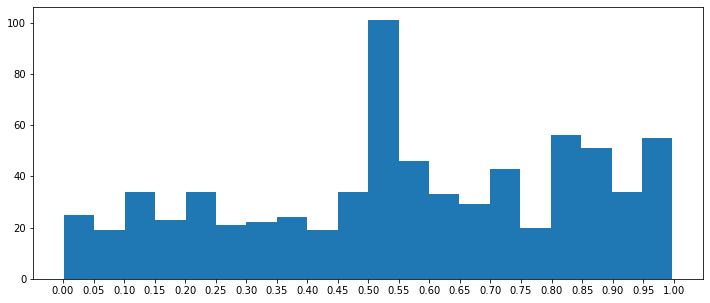

In [105]:
plt.figure(figsize = (12, 5)) 
plt.hist(similar_det.usd_perc_diff,bins = 20);
plt.xticks(np.arange(0, 1.05, 0.05));

<a href="#0"><h4>Back to top</h4></a>

<h5>Bitcoin "chains"?</h5>
<p id="5.3">

As I understand, all Bitcoin transactions, to be precise inputs and outputs, are parts of chains: every input is an output and every output becomes an input. Apart from newly minted coins (input, that has no prior output history) and outputs that are not (yet) spent (UTXO). 

When several similar BTC transactions are found, could it be that they are parts of the same input-output chain?
If not, then they are just unrelated to each other BTC transactions, that are similar to one bank transaction.
If yes, is it valuable information for the given challenge?
Could it be that instead of one BTC transfer, the "same" amount of BTC is sent from one to another and further along the "chain" in order to cover one's track?
From one hand, all transactions can be tracked, some platforms require identification. On the other hand, it is addresses that are tracked, so kind of anonymous.

I would determine such "chain" by the following criteria:<br>
-with every following part of "chain" btc_amount declines<br>
-decline of amount is within probable size of transaction(network) fee<br>
(in 2015-2017 average daily from 0.0001 to 0.003 BTC
https://ycharts.com/indicators/bitcoin_average_transaction_fee_btc )<br>
-output address of one transaction is among inputs addresses of the following, input address is among outputs addresses of the preceding (for the current dataset where in case of several inputs they are combined in sender column with space as delimiter: receiver has a nonempty intersection with sender splitted by space in list, and vice versa)

Further, such "chain" may be potentially related or not to somе bank transaction in the current challenge.
Criteria of "chain" related to bank transaction:<br>
-short period (making such a "chain"-transfer over several days is risky because of BTC volatility?) <br>
-if "chain" is from "before" bank transaction group, then "chain" should not proceed after the 'bank_begin_date' of bank transaction and USD amount of the last link should be higher than amount of bank transaction<br>
-if "chain" is from "after" group, then "chain" should not precede the 'bank_end_date' of bank transaction and USD amount of the first link should be lower than amount of bank transaction<br>
-if "chain" is from "before/after" group, then "chain" should not proceed during the period of bank transaction and USD amount of the last link before bank should be higher and of the first link should be lower than bank amount

Actually "one similar BTC" transactions might also be part of "chain", just only one link of the "chain" satisfied the criteria of conditional join.

If assume that such "chains" might make sense or at least make the transaction even more suspicious, then it would be useful to 
have a possibility to trace "chains" and check them for relation with bank transactions. In particular, check whether several similar BTC are unrelated BTC transactions or parts of "chains". Moreover, if BTC transactions are determined to be part of "chain", but that "chain" is determined to be unrelated to a bank transaction, then it might be an argument against crypto-related activity involved in this bank transaction. Same with "one similar BTC".

Draft of function that traces the "chain":

In [106]:
def trace_chain(btc_lim, day_lim, btc_list):
    
    '''
    Function goes through the list of BTC id (btc_list).
    At each time id is a "starting point" for search (b_id).
    Function searches for potential following/preceding link of "chain" in the btc_trans data. 
    If found, then "starting point" is changed to id of the found following/preceding link
    and search continues further.
    Function returns a dataframe with BTC ids determined as parts of "chains",
    index of "chain" and index of BTC id within the "chain".
    '''

    chain = pd.DataFrame()
    chain = pd.concat([chain, pd.DataFrame([{'btc_id': -100,'chain': -100, 'index': -100}])])
    # temporary row in order to set the columns

    for n, b_id in enumerate(btc_list):  

        if b_id not in chain.btc_id.unique(): 
        # to exclude the case: if btc_id duplicated or different btc_id are parts of the same "chain",
        # then "chain" will be recorded several times

            b_rec = bit_trans[bit_trans.btc_id == b_id].reset_index().loc[0,'receiver']
            b_send = bit_trans[bit_trans.btc_id == b_id].reset_index().loc[0,'sender']
            b_am = bit_trans[bit_trans.btc_id == b_id].reset_index().loc[0,'btc_amount']
            b_dat = bit_trans[bit_trans.btc_id == b_id].reset_index().loc[0,'btc_date']

            forw = (bit_trans[(bit_trans.btc_date.between(b_dat , b_dat + pd.DateOffset(days = day_lim))) &
                      (bit_trans.btc_amount.between(b_am - btc_lim , b_am )) &
                      (bit_trans.sender.str.contains(b_rec))])
            #"condition" for searching the following link

            backw = (bit_trans[(bit_trans.btc_date.between(b_dat - pd.DateOffset(days = day_lim), b_dat )) &
                  (bit_trans.btc_amount.between(b_am , b_am + btc_lim )) &
                  (bit_trans.receiver.isin(b_send.split(' ')))])
            #"condition" for searching the preceding link

            ind = 0
            # index within chain, "starting point"

            while len(forw) > 0:
            # loop searching links forwards in time from "starting point"

                if b_id not in chain.btc_id.unique():
                    row =  {'btc_id': b_id,'chain': n, 'index': ind}
                    chain = pd.concat([chain, pd.DataFrame([row])])
                    #record b_id ("starting point") from which search forwards

                ind += 1
                # index for the next found link of "chain"

                row1 =  {'btc_id': forw.reset_index().loc[0,'btc_id'],'chain': n, 'index': ind}
                # record the following link of "chain"
                # disadvantage: takes only the first row
                chain = pd.concat([chain, pd.DataFrame([row1])])

                i = forw.reset_index().loc[0,'btc_id'] 
                # change "starting point" for the next loop

                b_rec = bit_trans[bit_trans.btc_id == i].reset_index().loc[0,'receiver']
                b_send = bit_trans[bit_trans.btc_id == i].reset_index().loc[0,'sender']
                b_am = bit_trans[bit_trans.btc_id == i].reset_index().loc[0,'btc_amount']
                b_dat = bit_trans[bit_trans.btc_id == i].reset_index().loc[0,'btc_date']

                forw = (bit_trans[(bit_trans.btc_date.between(b_dat , b_dat + pd.DateOffset(days = day_lim))) &
                      (bit_trans.btc_amount.between(b_am - btc_lim , b_am )) &
                      (bit_trans.sender.str.contains(b_rec))])
                
            ind = 0
            # index within chain, "starting point" 

            while len(backw) > 0:
            # loop searching links backwards in time from "starting point"

                if b_id not in chain.btc_id.unique():
                    row =  {'btc_id': b_id,'chain': n, 'index': ind}
                    chain = pd.concat([chain, pd.DataFrame([row])])

                ind -= 1
                # index for the next found link of "chain"

                row1 =  {'btc_id': backw.reset_index().loc[0,'btc_id'],'chain': n, 'index': ind}
                chain = pd.concat([chain, pd.DataFrame([row1])])

                i = backw.reset_index().loc[0,'btc_id'] 

                b_rec = bit_trans[bit_trans.btc_id == i].reset_index().loc[0,'receiver']
                b_send = bit_trans[bit_trans.btc_id == i].reset_index().loc[0,'sender']
                b_am = bit_trans[bit_trans.btc_id == i].reset_index().loc[0,'btc_amount']
                b_dat = bit_trans[bit_trans.btc_id == i].reset_index().loc[0,'btc_date']

                backw = (bit_trans[(bit_trans.btc_date.between(b_dat - pd.DateOffset(days = day_lim), b_dat )) &
                      (bit_trans.btc_amount.between(b_am , b_am + btc_lim )) &
                      (bit_trans.receiver.isin(b_send.split(' ')))])
    
    chain = chain[chain.btc_id > 0]
    # drop temporary row
    
    return chain

Run the function with parameters:
* limit of difference in BTC amounts of adjacent links (btc_lim): maximum average daily transaction fee of this period (0.003)
* limit of difference in dates between links (day_lim): let it be 3 days
* list of BTC transactions for each of which "chain" is traced (btc_list): found BTC transactions from the conditional join

In [107]:
%%time
chain = trace_chain(0.003, 3, similar_det['btc_id'].unique())

Wall time: 3min 58s


Merge the result of function with details of BTC transactions:

In [108]:
chain_det = chain.merge(bit_trans, how = 'left', on = 'btc_id')

Convert dates to a more readable format when write the result to Excel:

In [109]:
chain_det_exc = chain_det.copy()
chain_det_exc['btc_date'] = chain_det_exc['btc_date'].dt.strftime('%d.%m.%Y')

Write the found "chains" to Excel:

In [110]:
chain_det_exc.sort_values(['chain','index']).to_excel('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\chains.xlsx', index = False)

Found 19 "chains" with 98 BTC outputs/transactions:

In [111]:
print('chains: ', chain_det.chain.nunique())
print('btc: ', chain_det.btc_id.nunique())

chains:  19
btc:  98


Match the conditional join result with "chains" data:

In [112]:
sim_det_chain = similar_det.merge(chain, how = 'left', on = 'btc_id')

Set convenient order for reading:

In [113]:
col = ['id','originator_bank_id','beneficiary_bank_id','bank_begin_date','bank_end_date',
     'bank_trans_number','bank_trans_usd',
       'before_after', 'one_several', 'chain', 'index',
    'btc_usd_amount', 'usd_perc_diff', 'date_diff','btc_amount',
     'btc_id', 'btc_date', 'sender', 'receiver', 'hash',
        'price', 'filer_org_name_id','icij_sar_id', 'filer_org_name', 
       'originator_bank_id', 'beneficiary_bank_id', 'beneficiary_bank',
       'beneficiary_bank_country', 'beneficiary_iso']

In [114]:
pd.set_option('display.max_columns', 100)

Parts of "chains" relate only to 6 bank transactions:

In [115]:
ch_list_id = sim_det_chain[sim_det_chain.chain > 0].id.unique()
len(ch_list_id)

6

Consider the example of such a bank transaction. Actually 13 transactions were made between 2015-12-04 and 2016-05-11. As a result of the conditional join several similar BTC transactions were found, some one day before the bank_begin_date and some on the same day. Two of them were determined as parts of "chain" and made on the same day. Probably these BTC transactions may be considered as the most suspicious. One the other hand, it can be seen from the sender and receiver that this "chain" is a back and forth transaction. Probably it might be an argument against the relation of these BTC transactions to this bank transaction.

In [116]:
sim_det_chain[sim_det_chain.id == ch_list_id[1]][col].sort_values(['btc_date','chain','index'])

,id,originator_bank_id,beneficiary_bank_id,bank_begin_date,bank_end_date,bank_trans_number,bank_trans_usd,before_after,one_several,chain,index,btc_usd_amount,usd_perc_diff,date_diff,btc_amount,btc_id,btc_date,sender,receiver,hash,price,filer_org_name_id,icij_sar_id,filer_org_name,originator_bank_id,beneficiary_bank_id,beneficiary_bank,beneficiary_bank_country,beneficiary_iso
116,227498,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,2015-12-04,2016-05-11,13.00,1786929.08,before,several,NaN,NaN,1797692.08,0.60,-1 days,4971.38,6329,2015-12-03,1AWbarf3zC1KaAxdHjiygG45AcQujnomw1,13TcFnveSnuKNrmdfh1Yrgo4ZE72siVRAE,a831d6855ebf68f93ac11aea1a9300e63d39bd4ed2de61...,361.61,the-bank-of-new-york-mellon-corp,3789,The Bank of New York Mellon Corp.,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,DBS Bank Ltd,Singapore,SGP
117,227498,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,2015-12-04,2016-05-11,13.00,1786929.08,before,several,NaN,NaN,1799737.58,0.72,-1 days,4977.03,6331,2015-12-03,1Kh4vNbp8M8TR58y3ewnQpGEjH7b5Vdx3f,1AWbarf3zC1KaAxdHjiygG45AcQujnomw1,535af08aa1facdc0da40172b73253c6695d62c82c6a323...,361.61,the-bank-of-new-york-mellon-corp,3789,The Bank of New York Mellon Corp.,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,DBS Bank Ltd,Singapore,SGP
118,227498,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,2015-12-04,2016-05-11,13.00,1786929.08,before,several,NaN,NaN,1799809.94,0.72,-1 days,4977.23,6332,2015-12-03,1N22Xzy4FhuHfYNgQqit4NnZpNkgfkFvdS,1Kh4vNbp8M8TR58y3ewnQpGEjH7b5Vdx3f,08e5eb3a1a0ffdc855f19b1f09025d51c14730aafe0070...,361.61,the-bank-of-new-york-mellon-corp,3789,The Bank of New York Mellon Corp.,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,DBS Bank Ltd,Singapore,SGP
113,227498,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,2015-12-04,2016-05-11,13.00,1786929.08,before,several,113.00,0.00,1802368.10,0.86,0 days,5000.00,6228,2015-12-04,3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw 3QkziVUYpro...,34UbND7PaFRZT1799hhTnqPV9KHFdfRYh7,0233206437de5181209db0620d0ad2d28561af2983f321...,360.47,the-bank-of-new-york-mellon-corp,3789,The Bank of New York Mellon Corp.,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,DBS Bank Ltd,Singapore,SGP
114,227498,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,2015-12-04,2016-05-11,13.00,1786929.08,before,several,113.00,1.00,1802367.97,0.86,0 days,5000.00,6230,2015-12-04,34UbND7PaFRZT1799hhTnqPV9KHFdfRYh7 31u3ydojhM7...,3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw,f3161629d8b7dd4bc8fe396513f64b57fc952b40f3aada...,360.47,the-bank-of-new-york-mellon-corp,3789,The Bank of New York Mellon Corp.,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,DBS Bank Ltd,Singapore,SGP
111,227498,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,2015-12-04,2016-05-11,13.00,1786929.08,before,several,NaN,NaN,1788362.49,0.08,0 days,4961.15,6203,2015-12-04,1Bzcrtsy3FjrTmTbB8dsvBmGGCsadnXPFW,3AGcNMjFf6fSxe31gH9YQZj3fSUh2UxkaB,869dfb5d545f0e25cc4166d3ccfabc1ba6119b8eda556d...,360.47,the-bank-of-new-york-mellon-corp,3789,The Bank of New York Mellon Corp.,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,DBS Bank Ltd,Singapore,SGP
112,227498,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,2015-12-04,2016-05-11,13.00,1786929.08,before,several,NaN,NaN,1802368.05,0.86,0 days,5000.00,6204,2015-12-04,3AGcNMjFf6fSxe31gH9YQZj3fSUh2UxkaB,1Bzcrtsy3FjrTmTbB8dsvBmGGCsadnXPFW,fa8526ec484608a3496946ee8e05fd5e3764be2f84b80b...,360.47,the-bank-of-new-york-mellon-corp,3789,The Bank of New York Mellon Corp.,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,DBS Bank Ltd,Singapore,SGP
115,227498,united-overseas-bank-limited,dbs-bank-ltd-singapore-sgp,2015-12-04,2016-05-11,13.00,1786929.08,before,several,NaN,NaN,1802368.05,0.86,0 days,5000.00,6232,2015-12-04,3Pww538PKNLJVLTtBPnJN33151urPKqSNk 3Jy37hjbov3...,18mkjbVaHAcMauL6iiy7zm9VjMYCjy4UU1,cd51ef78a8f453adcdcb2eb059b43609e392d97f7145c3...,360.47,the-bank-of-new-york-mellon-corp,3789,The Bank of New Yor

Another example of such a bank transaction. Actually 4 transactions were made between 2016-08-01	and 2016-08-31. As a result of the conditional join two similar BTC transactions were found, two days after the bank_end_date. Both of them were determined as parts of "chain" and made on the same day. So probably these BTC transactions may be considered as more suspicious. In addition, the first link in this chain has an USD amount lower than bank amount, and it might be an extra argument for relation with this bank transaction.  

In [117]:
sim_det_chain[sim_det_chain.id == ch_list_id[5]][col].sort_values(['btc_date','chain','index'])

,id,originator_bank_id,beneficiary_bank_id,bank_begin_date,bank_end_date,bank_trans_number,bank_trans_usd,before_after,one_several,chain,index,btc_usd_amount,usd_perc_diff,date_diff,btc_amount,btc_id,btc_date,sender,receiver,hash,price,filer_org_name_id,icij_sar_id,filer_org_name,originator_bank_id,beneficiary_bank_id,beneficiary_bank,beneficiary_bank_country,beneficiary_iso
667,239768,versobank-as,vtb-bank-kyiv-ukraine-ukr,2016-08-01,2016-08-31,4.00,2286437.26,after,several,663.00,-1.00,2281788.50,0.20,2 days,3988.92,69835,2016-09-02,3PQ4BW6X4kQrpWZT4xoDq9pE8HJYs1nZxZ 35KqXhcmeSy...,1HqxSZqr3HGKDFskoRkbS1TWnAxkpbruQF,edea1cec5d6bcadc7a85d1bc57819f13319f35543e490a...,572.03,the-bank-of-new-york-mellon-corp,3683,The Bank of New York Mellon Corp.,versobank-as,vtb-bank-kyiv-ukraine-ukr,VTB Bank,Ukraine,UKR
666,239768,versobank-as,vtb-bank-kyiv-ukraine-ukr,2016-08-01,2016-08-31,4.00,2286437.26,after,several,663.00,0.00,2281788.50,0.20,2 days,3988.92,69833,2016-09-02,1HqxSZqr3HGKDFskoRkbS1TWnAxkpbruQF 1NounBMGodd...,1KwA4fS4uVuCNjCtMivE7m5ATbv93UZg8V,969b89425d85562ef2501150945115d5de3d7e86f8612d...,572.03,the-bank-of-new-york-mellon-corp,3683,The Bank of New York Mellon Corp.,versobank-as,vtb-bank-kyiv-ukraine-ukr,VTB Bank,Ukraine,UKR


Write bank transactions for which parts of "chains" were found among similar BTC to Excel:

In [118]:
sim_det_chain_exc = sim_det_chain[sim_det_chain.id.isin(ch_list_id)].copy()
sim_det_chain_exc['btc_date'] = sim_det_chain_exc['btc_date'].dt.strftime('%d.%m.%Y')
sim_det_chain_exc['bank_begin_date'] = sim_det_chain_exc['bank_begin_date'].dt.strftime('%d.%m.%Y')
sim_det_chain_exc['bank_end_date'] = sim_det_chain_exc['bank_end_date'].dt.strftime('%d.%m.%Y')

In [119]:
sim_det_chain_exc[col].sort_values(['id','chain','index']).to_excel('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\similar_chain.xlsx', index = False)

Add the column to the result of conditional join marking the BTC transactions which are parts of potential "chain":

In [120]:
chain_btc_id = chain.btc_id.unique()
similar_det['chain'] = similar_det.apply(lambda row: 'chain' if row.btc_id in chain_btc_id else 'not', axis = 1)

Most of BTC that are parts of potential "chains" are in before-several group:

In [121]:
similar_det.groupby(['before_after','one_several','chain'])['bank_trans_usd'].count().to_frame()

bank_trans_usd
before_after one_several chain                
after        one         not                23
             several     chain               2
                         not               126
before       one         not                22
             several     chain              85
                         not               132
before/after several     chain               6
                         not               327

In [122]:
col = ['id','originator_bank_id','beneficiary_bank_id','bank_begin_date','bank_end_date',
     'bank_trans_number','bank_trans_usd',
       'before_after', 'one_several', 'chain',
    'btc_usd_amount', 'usd_perc_diff', 'date_diff','btc_amount',
     'btc_id', 'btc_date', 'sender', 'receiver', 'hash',
        'price', 'filer_org_name_id','icij_sar_id', 'filer_org_name', 
       'originator_bank_id', 'beneficiary_bank_id', 'beneficiary_bank',
       'beneficiary_bank_country', 'beneficiary_iso']

Convert dates to a more convenient format when write the result to Excel:

In [123]:
similar_det_exc = similar_det.copy()
similar_det_exc['btc_date'] = similar_det_exc['btc_date'].dt.strftime('%d.%m.%Y')
similar_det_exc['bank_begin_date'] = similar_det_exc['bank_begin_date'].dt.strftime('%d.%m.%Y')
similar_det_exc['bank_end_date'] = similar_det_exc['bank_end_date'].dt.strftime('%d.%m.%Y')

Write the conditional join result to Excel:

In [124]:
similar_det_exc[col].sort_values(['id','bank_begin_date','btc_date']).to_excel('C:\\python\\portfolio\\english\\data_analysis_python\\bank_bitcoin_match\\similar_det.xlsx', index = False)

<a href="#0"><h4>Back to top</h4></a>